# Linear Regression
## Bike Sharing Casing Study

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')

## Step 1: Reading & Understanding the Data

In [2]:
df_bike_day = pd.read_csv("day.csv")
df_bike_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Data Dictionary:
day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [3]:
print(f'shape: {df_bike_day.shape}')
df_bike_day.info()

shape: (730, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [4]:
df_bike_day.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


## Data Quality Check & Data Cleaning

In [5]:
# No.of missing values in each column
df_bike_day.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

_Observation_: There are no missing data

In [6]:
# Checking for duplicate values
bike_dup = df_bike_day.copy()

# Checking for duplicates and dropping the entire duplicate row if any
bike_dup.drop_duplicates(subset=None, inplace=True)
print(f'Shape after dropping Duplicates: {bike_dup.shape}')

print(f'Shape before dropping Duplicates: {df_bike_day.shape}')

Shape after dropping Duplicates: (730, 16)
Shape before dropping Duplicates: (730, 16)


_Observation_: No Duplicates are present

In [7]:
# instant is an index column, so dropping it
df_bike_day.drop(['instant'],axis=1,inplace=True)

In [8]:
# it's known that casual + registered = cnt and cnt is target variable 
# Hence, not considering casual and registered
df_bike_day.drop(['casual','registered'],axis=1,inplace=True)

In [9]:
df_bike_day.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [10]:
# column dteday and yr, month are having same data, so dropping dteday to avoid confusion

df_bike_day.drop(['dteday'],axis=1,inplace=True)
df_bike_day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


### Converting the ordinal data into categories

In [11]:
# Checking Categorical Valiables 
print(df_bike_day.season.value_counts())
print(df_bike_day.yr.value_counts())
print(df_bike_day.mnth.value_counts())
print(df_bike_day.holiday.value_counts())
print(df_bike_day.weekday.value_counts())
print(df_bike_day.workingday.value_counts())
print(df_bike_day.weathersit.value_counts())

season
3    188
2    184
1    180
4    178
Name: count, dtype: int64
yr
0    365
1    365
Name: count, dtype: int64
mnth
1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: count, dtype: int64
holiday
0    709
1     21
Name: count, dtype: int64
weekday
6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: count, dtype: int64
workingday
1    499
0    231
Name: count, dtype: int64
weathersit
1    463
2    246
3     21
Name: count, dtype: int64


In [12]:
import calendar
df_bike_day['mnth'] = df_bike_day['mnth'].apply(lambda x: calendar.month_abbr[x])
df_bike_day.season = df_bike_day.season.map({1: 'Spring',2:'Summer',3:'Fall',4:'Winter'})
df_bike_day.weathersit = df_bike_day.weathersit.map({1:'Clear',2:'Mist & Cloudy',3:'Light Snow & Rain',4:'Heavy Snow & Rain'})
df_bike_day.weekday = df_bike_day.weekday.map({5:"Sunday",6:"Monday",0:"Tuesday",1:"Wednesday",2:"Thrusday",3:"Friday",4:"Saturday"})
df_bike_day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,0,Jan,0,Monday,0,Mist & Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,Spring,0,Jan,0,Tuesday,0,Mist & Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,Spring,0,Jan,0,Wednesday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,0,Jan,0,Thrusday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,0,Jan,0,Friday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


## Step 2: Performing EDA

In [13]:
# segregatinf variable to easily plot them
continuous_vars = ['temp', 'atemp','hum', 'windspeed']
categorical_vars = ['yr', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
target_vars = ['cnt']

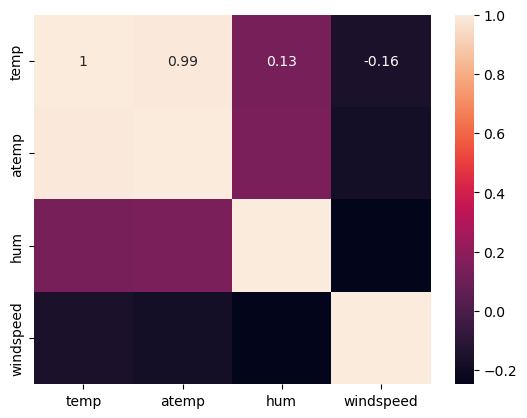

In [14]:
sns.heatmap(df_bike_day[continuous_vars].corr(), annot=True)
plt.show()

_Observation_: Since temp and atemp are highly corelated, Dropping one of them

In [15]:
df_bike_day.drop(['atemp'], axis = 1, inplace = True)
continuous_vars.remove('atemp')

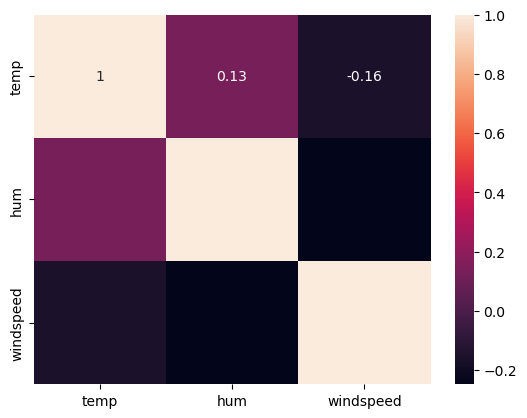

In [16]:
sns.heatmap(df_bike_day[continuous_vars].corr(), annot=True)
plt.show()

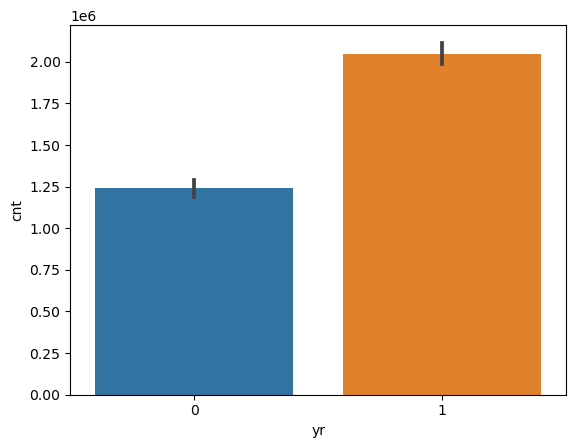

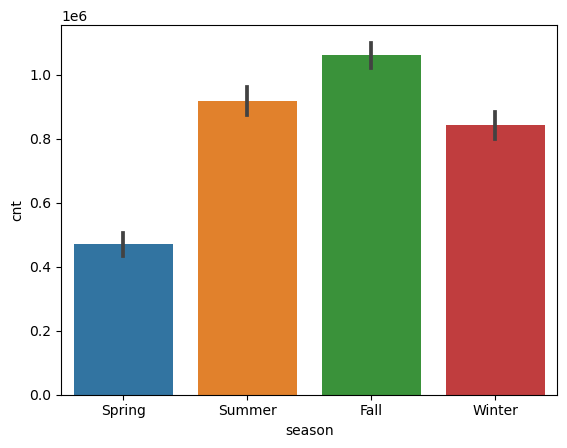

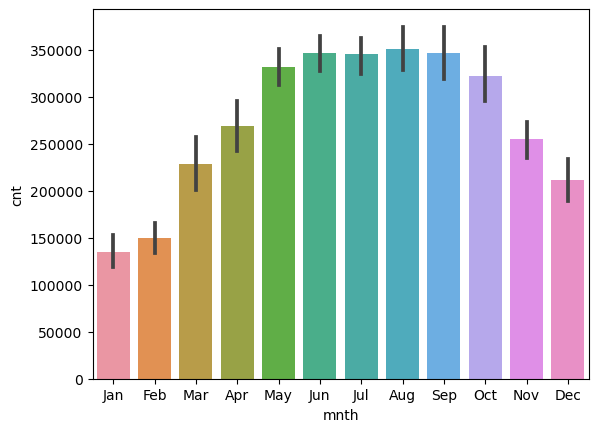

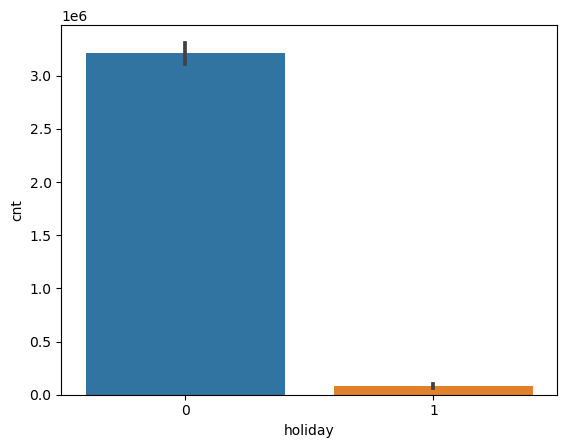

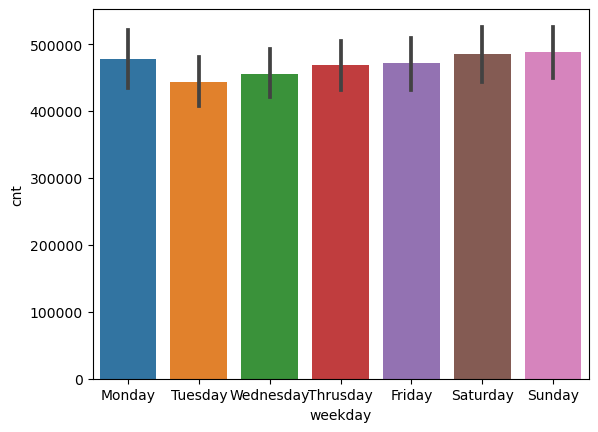

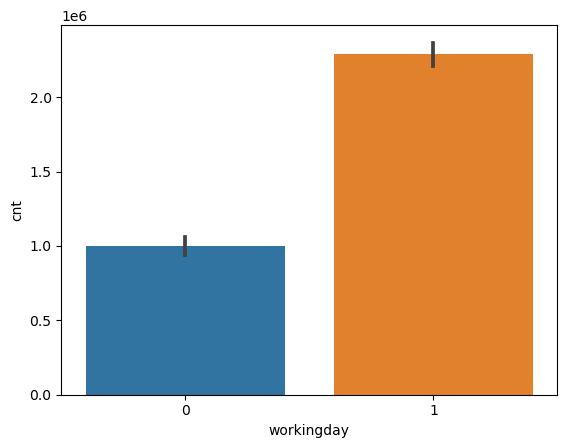

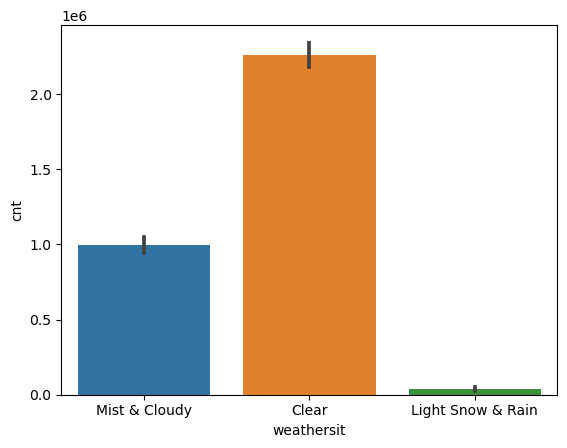

In [17]:
for i in categorical_vars:
    for j in target_vars:
        sns.barplot(x=df_bike_day[i], y=df_bike_day[j], estimator=sum)
        plt.show()

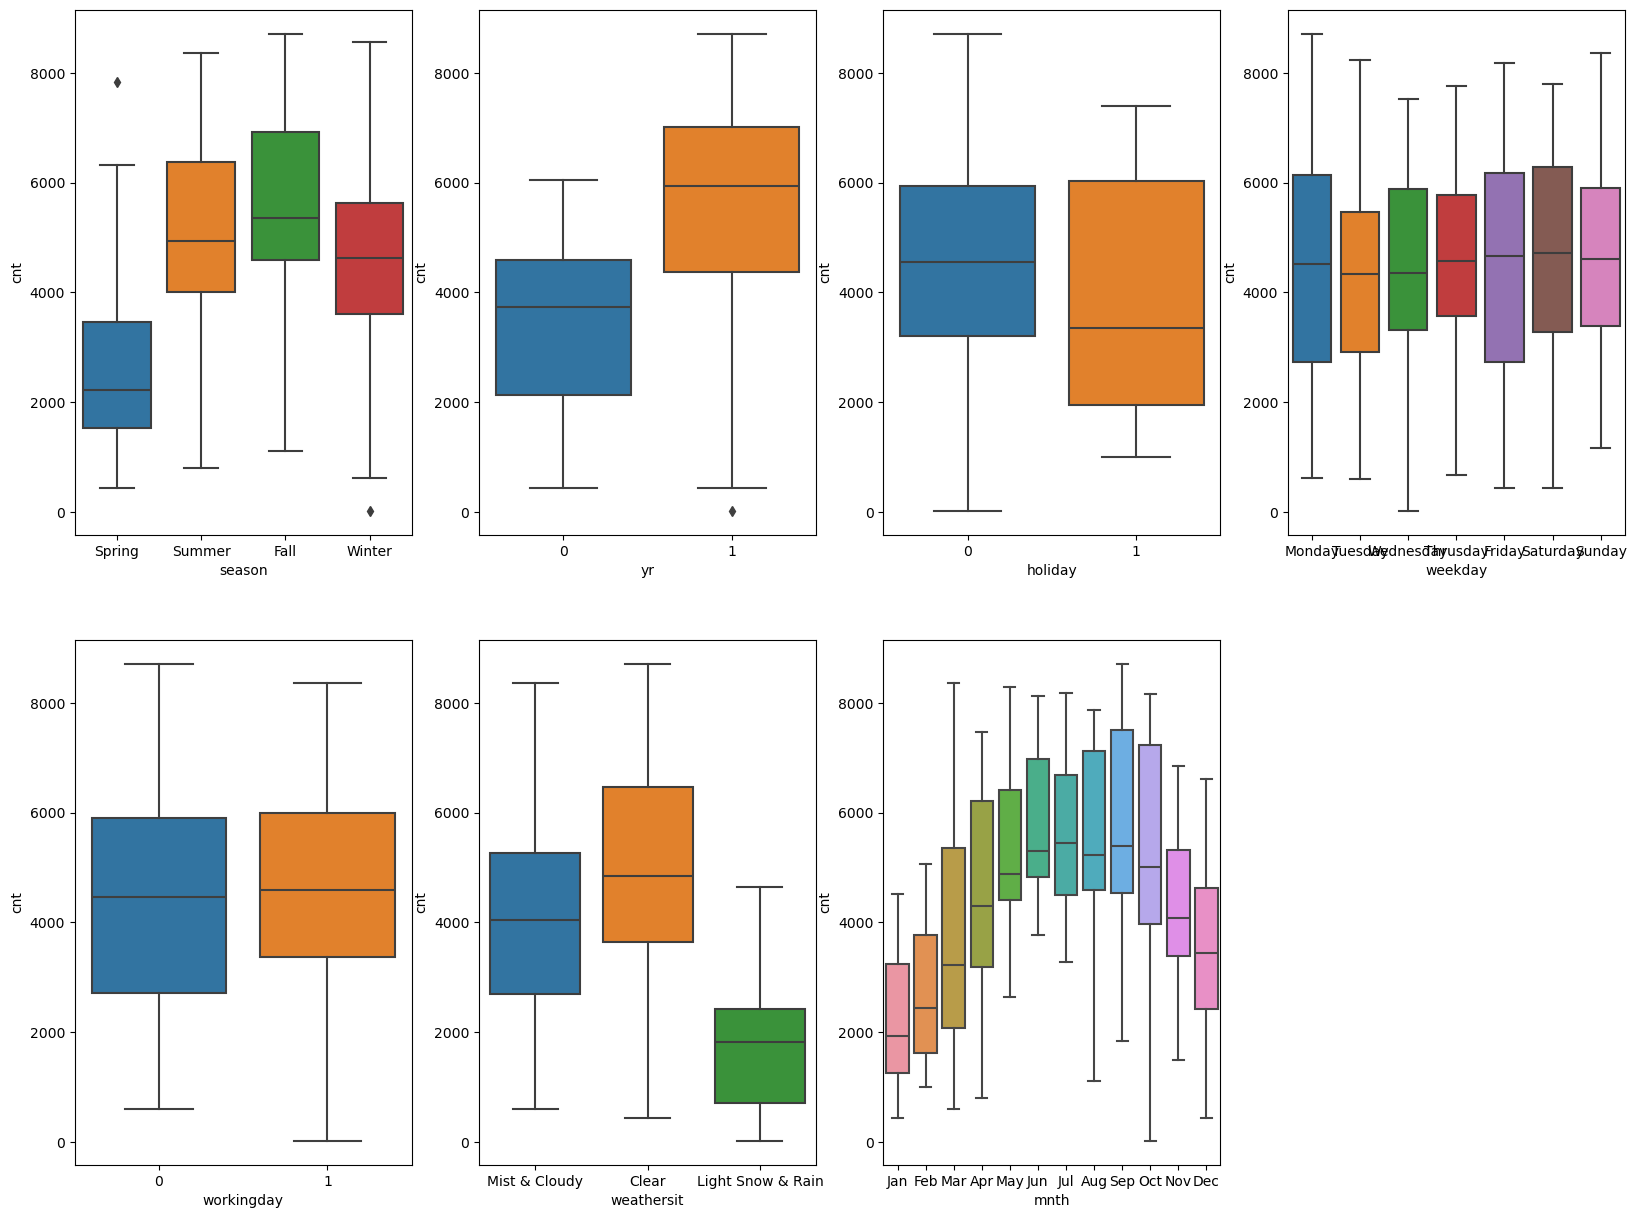

In [18]:
plt.figure(figsize=(20, 15))
plt.subplot(2,4,1)
sns.boxplot(x = 'season', y = 'cnt', data = df_bike_day)
plt.subplot(2,4,2)
sns.boxplot(x = 'yr', y = 'cnt', data = df_bike_day)
plt.subplot(2,4,3)
sns.boxplot(x = 'holiday', y = 'cnt', data = df_bike_day)
plt.subplot(2,4,4)
sns.boxplot(x = 'weekday', y = 'cnt', data = df_bike_day)
plt.subplot(2,4,5)
sns.boxplot(x = 'workingday', y = 'cnt', data = df_bike_day)
plt.subplot(2,4,6)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df_bike_day)
plt.subplot(2,4,7)
sns.boxplot(x = 'mnth', y = 'cnt', data = df_bike_day)
plt.show()

_Observations_:
- There is a significant rise in users i.e., riders from year 2018 to 2019. (0: 2018, 1:2019)
- bikes have more demand in Summer and Fall season
- May-Oct have demand for bikes compared to other Months
- September has the highest count of riders and January has lowest among all the months
- Users use boom bikes more on non-holiday days & working days
- Also users prefer is mostly on CLear weather

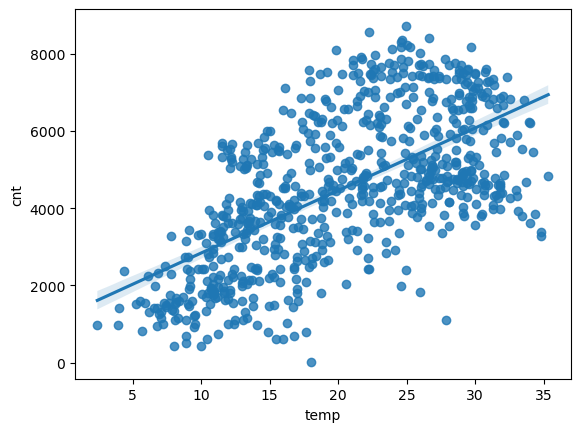

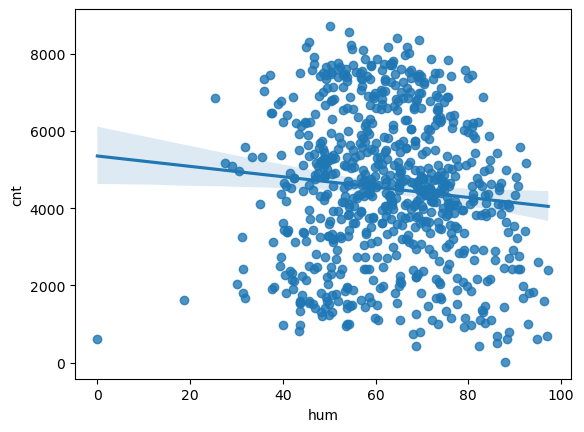

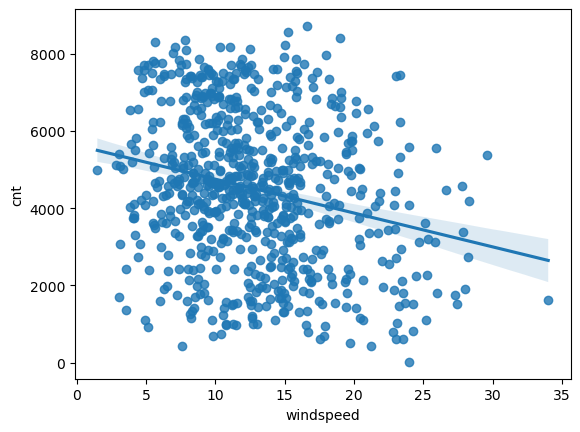

In [19]:
for i in continuous_vars:
    for j in target_vars:
        sns.regplot(x=i, y=j, data=df_bike_day)
        plt.show()

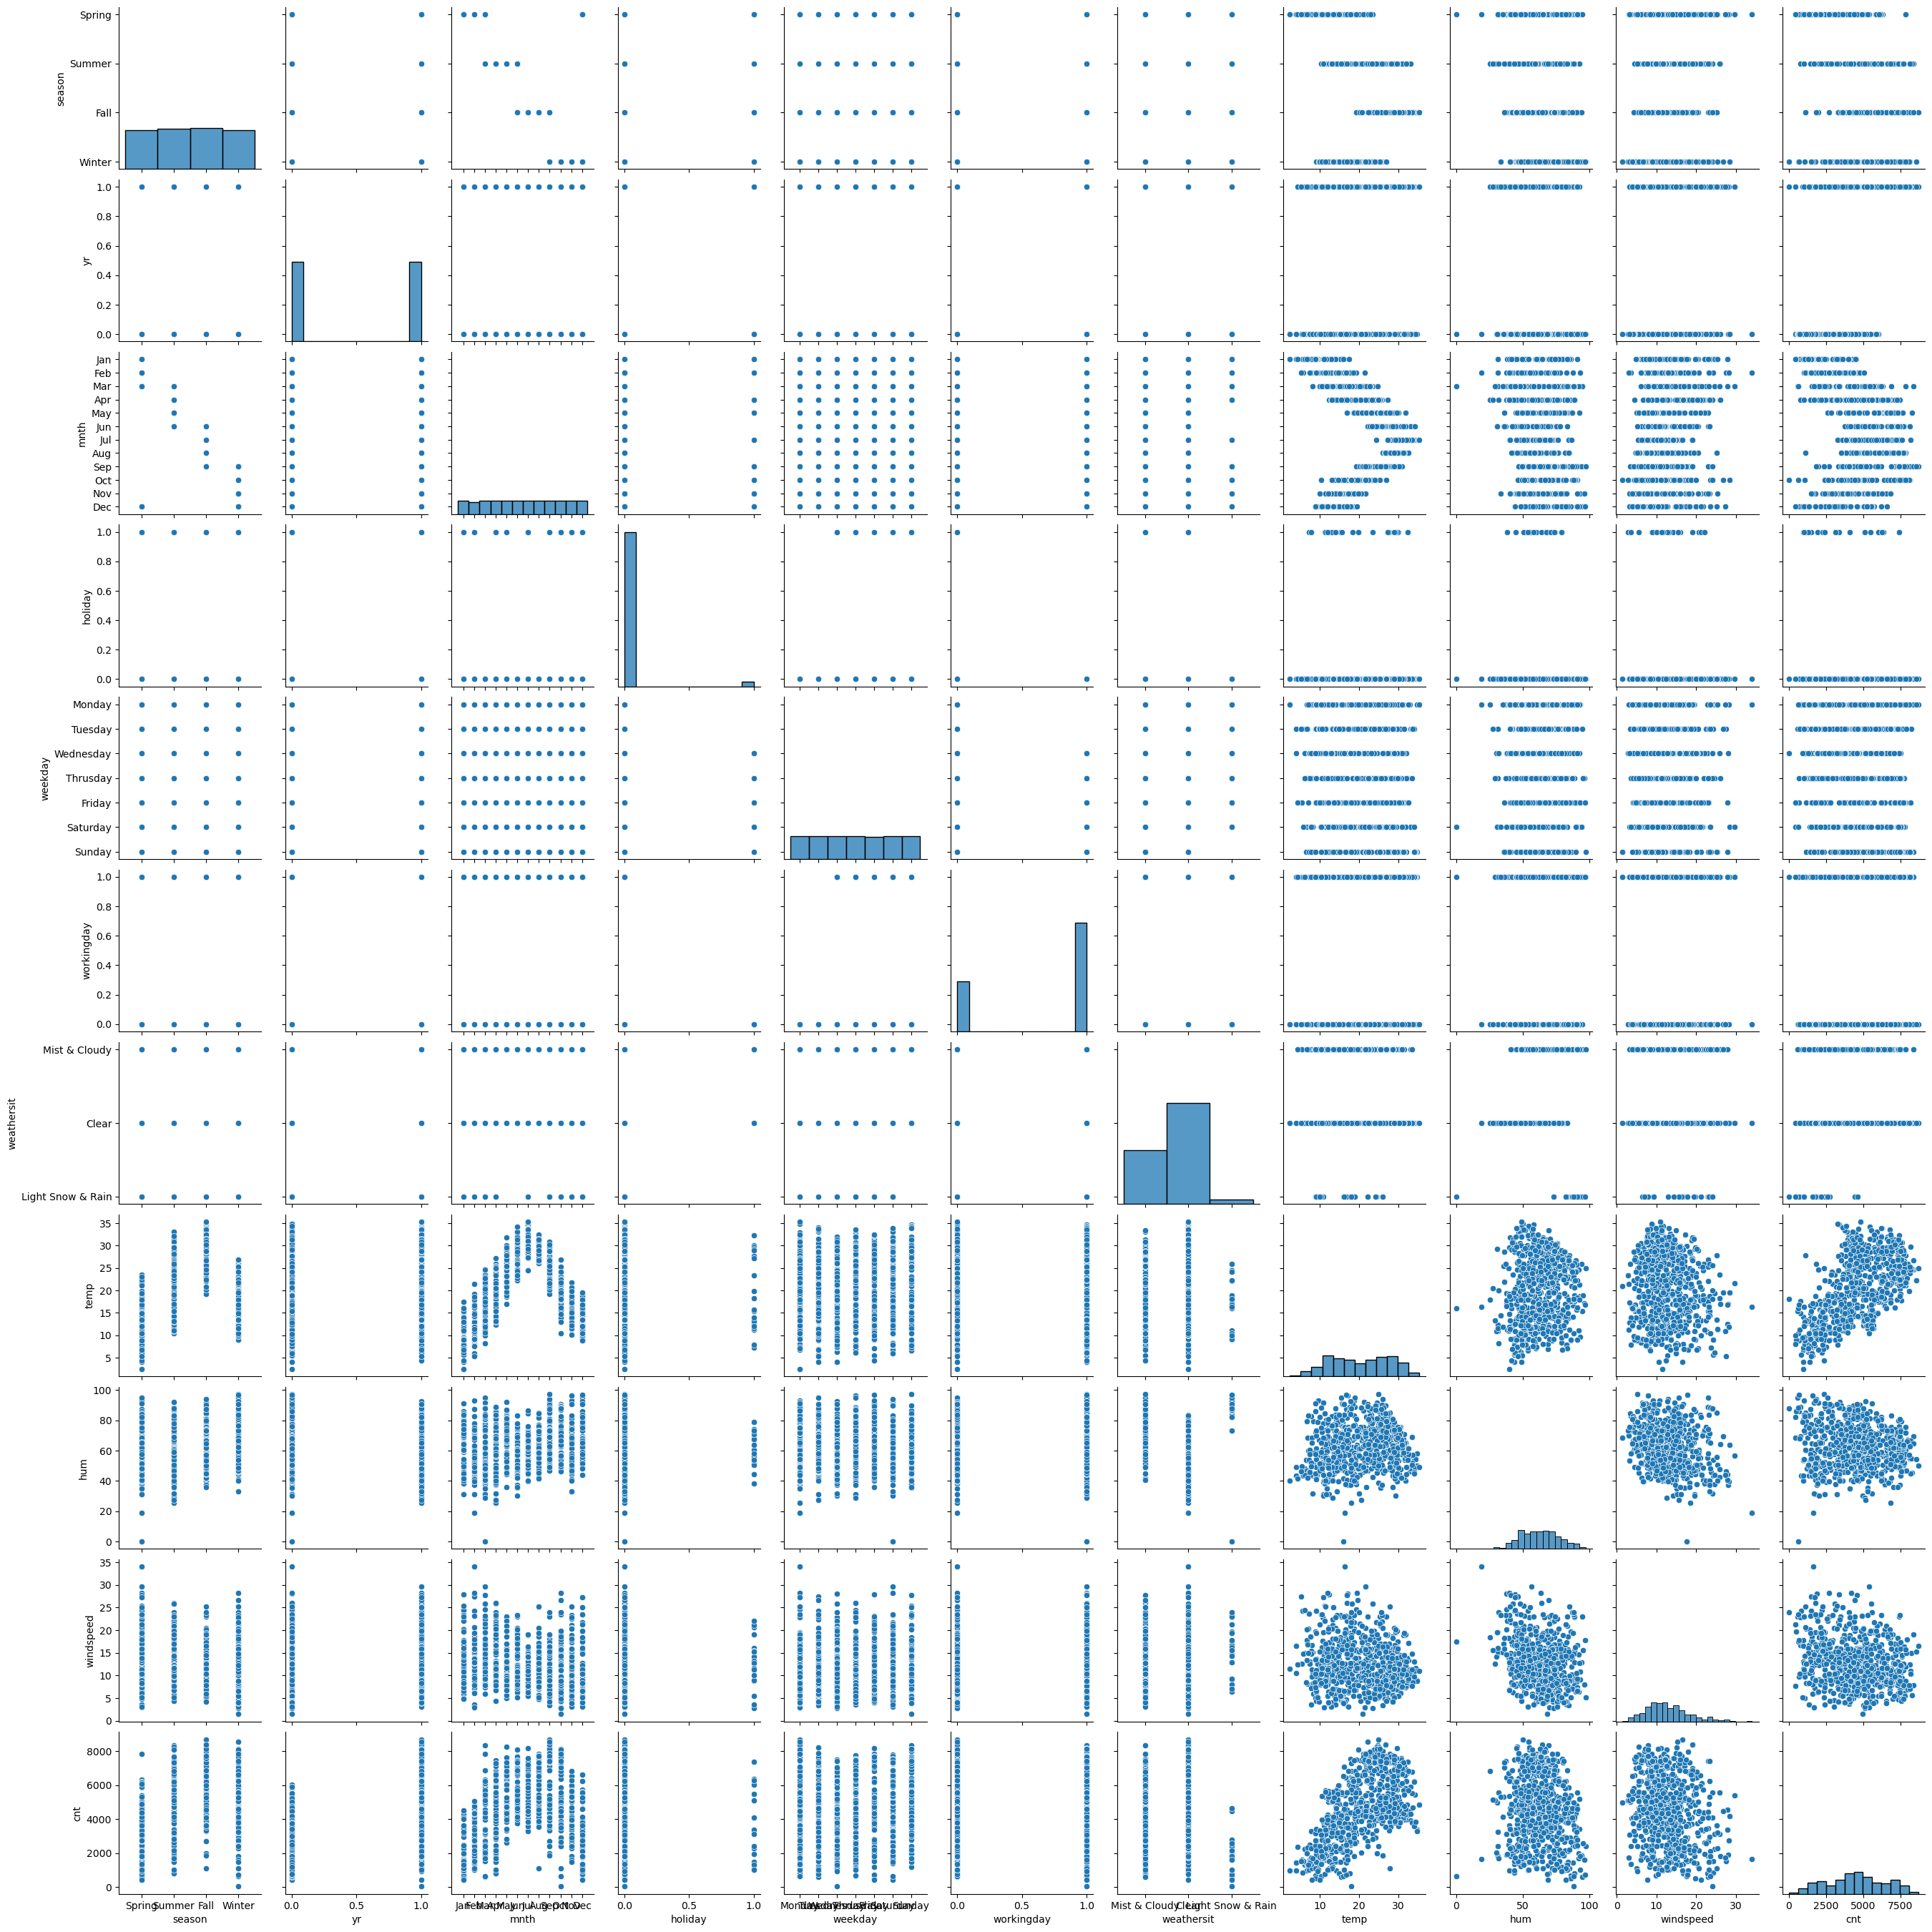

In [20]:
sns.pairplot(data = df_bike_day, vars=df_bike_day.columns)
plt.show()

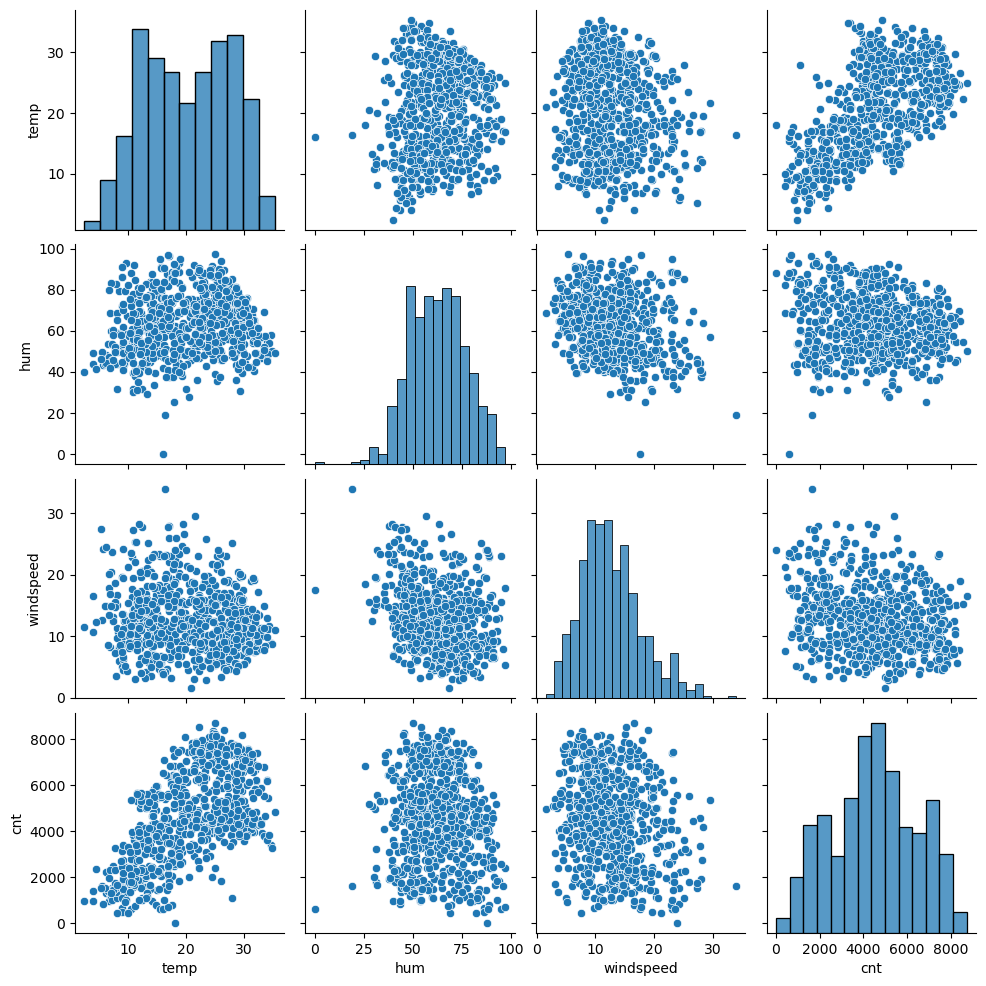

In [21]:
sns.pairplot(data = df_bike_day, vars= continuous_vars + target_vars )
plt.show()

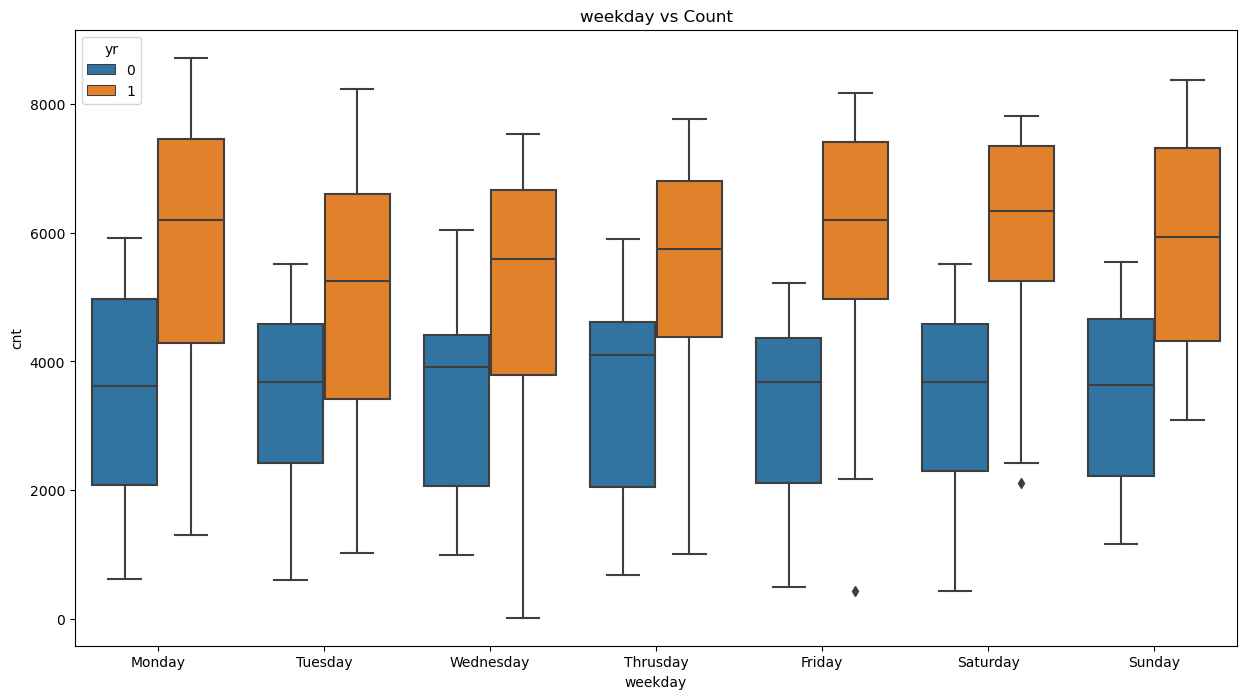

In [22]:
plt.figure(figsize = (15, 8))
sns.boxplot(x = 'weekday', y = 'cnt', hue = 'yr', data = df_bike_day)
plt.title('weekday vs Count')
plt.show()

_Observations :_ The count of riders is higher in 2019 as opposed to 2018 across all the days of the week

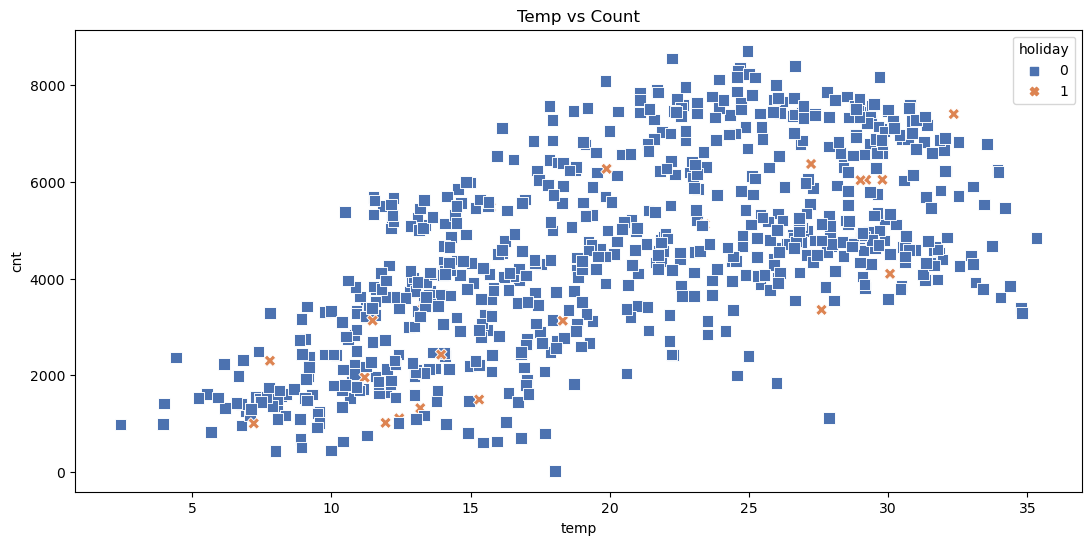

In [23]:
plt.figure(figsize = (13, 6)) 
markers = {1: "X", 0: "s"}
sns.scatterplot(x = 'temp', y = 'cnt', hue = 'holiday',
                style = 'holiday',palette="deep",s=70,
                markers=markers,data = df_bike_day) 
plt.title('Temp vs Count')
plt.show()

## Step 3: Data Preparation

#### Encoding Data

In [24]:
df_bike_day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,Spring,0,Jan,0,Monday,0,Mist & Cloudy,14.110847,80.5833,10.749882,985
1,Spring,0,Jan,0,Tuesday,0,Mist & Cloudy,14.902598,69.6087,16.652113,801
2,Spring,0,Jan,0,Wednesday,1,Clear,8.050924,43.7273,16.636703,1349
3,Spring,0,Jan,0,Thrusday,1,Clear,8.200000,59.0435,10.739832,1562
4,Spring,0,Jan,0,Friday,1,Clear,9.305237,43.6957,12.522300,1600


_Observation_: For categorical Data with more than 2 categories, dummy variables are created.
Here, dummy variables are created for 'season', 'mnth', 'weekday', 'weathersit'

In [25]:
# Creating the dummy variables for the feature 'mnth'
dummy_month = pd.get_dummies(df_bike_day['mnth'],drop_first = True).astype(int)
dummy_month.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [26]:
# Creating the dummy variables for the feature 'season'
dummy_season = pd.get_dummies(df_bike_day['season'],drop_first = True).astype(int)
dummy_season.head()

,Spring,Summer,Winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [27]:
# Creating the dummy variables for the feature 'weekday'
dummy_weekday = pd.get_dummies(df_bike_day['weekday'],drop_first = True).astype(int)
dummy_weekday.head()

,Monday,Saturday,Sunday,Thrusday,Tuesday,Wednesday
0,1,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,0,0,0


In [28]:
# Creating the dummy variables for the feature 'weathersit'
dummy_weathersit = pd.get_dummies(df_bike_day['weathersit'],drop_first = True).astype(int)
dummy_weathersit.head()

,Light Snow & Rain,Mist & Cloudy
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0


In [29]:
df_bike_final = pd.concat([df_bike_day, dummy_month, dummy_season, dummy_weekday, dummy_weathersit], axis=1)

In [30]:
# Dropping the columns
df_bike_final = df_bike_final.drop(['season','mnth','weekday','weathersit'],axis=1)
df_bike_final.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,Aug,Dec,Feb,...,Summer,Winter,Monday,Saturday,Sunday,Thrusday,Tuesday,Wednesday,Light Snow & Rain,Mist & Cloudy
0,0,0,0,14.110847,80.5833,10.749882,985,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,801,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Checking the statistical values 
df_bike_final.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,Aug,Dec,Feb,...,Summer,Winter,Monday,Saturday,Sunday,Thrusday,Tuesday,Wednesday,Light Snow & Rain,Mist & Cloudy
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,...,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.683562,20.319259,62.765175,12.763620,4508.006849,0.084932,0.084932,0.076712,...,0.252055,0.243836,0.143836,0.142466,0.142466,0.142466,0.143836,0.143836,0.028767,0.336986
std,0.500343,0.167266,0.465405,7.506729,14.237589,5.195841,1936.011647,0.278971,0.278971,0.266317,...,0.434490,0.429689,0.351164,0.349767,0.349767,0.349767,0.351164,0.351164,0.167266,0.473004
min,0.000000,0.000000,0.000000,2.424346,0.000000,1.500244,22.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,13.811885,52.000000,9.041650,3169.750000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.000000,1.000000,20.465826,62.625000,12.125325,4548.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,26.880615,72.989575,15.625589,5966.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,35.328347,97.250000,34.000021,8714.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Step 4: Splitting the Data into Training and Testing Sets

In [32]:
# Spliting the data (70: 30)
df_train, df_test = train_test_split(df_bike_final, train_size = 0.7, test_size = 0.3, random_state = 100)

In [33]:
# printing the shape of test and train data set
print(df_train.shape)
print(df_test.shape)

(510, 29)
(219, 29)


#### Rescalling the features

In [34]:
scaler = MinMaxScaler()

In [35]:
num_vars = ['cnt', 'temp', 'hum','windspeed']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,Aug,Dec,Feb,...,Summer,Winter,Monday,Saturday,Sunday,Thrusday,Tuesday,Wednesday,Light Snow & Rain,Mist & Cloudy
653,1,0,1,0.509887,0.575354,0.300794,0.864243,0,0,0,...,0,1,0,0,0,1,0,0,0,0
576,1,0,1,0.815169,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,1,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0.465255,0,0,0,...,0,0,1,0,0,0,0,0,0,1
728,1,0,0,0.245101,0.498067,0.663106,0.204096,0,1,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.482973,0,0,0,...,1,0,1,0,0,0,0,0,0,1


In [36]:
df_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,Aug,Dec,Feb,...,Summer,Winter,Monday,Saturday,Sunday,Thrusday,Tuesday,Wednesday,Light Snow & Rain,Mist & Cloudy
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.00000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537262,0.650369,0.320768,0.513620,0.096078,0.084314,0.066667,...,0.245098,0.24902,0.154902,0.133333,0.127451,0.131373,0.143137,0.150980,0.029412,0.343137
std,0.500429,0.157763,0.468282,0.225844,0.145882,0.169797,0.224593,0.294988,0.278131,0.249689,...,0.430568,0.43287,0.362166,0.340268,0.333805,0.338139,0.350557,0.358381,0.169124,0.475223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.540519,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


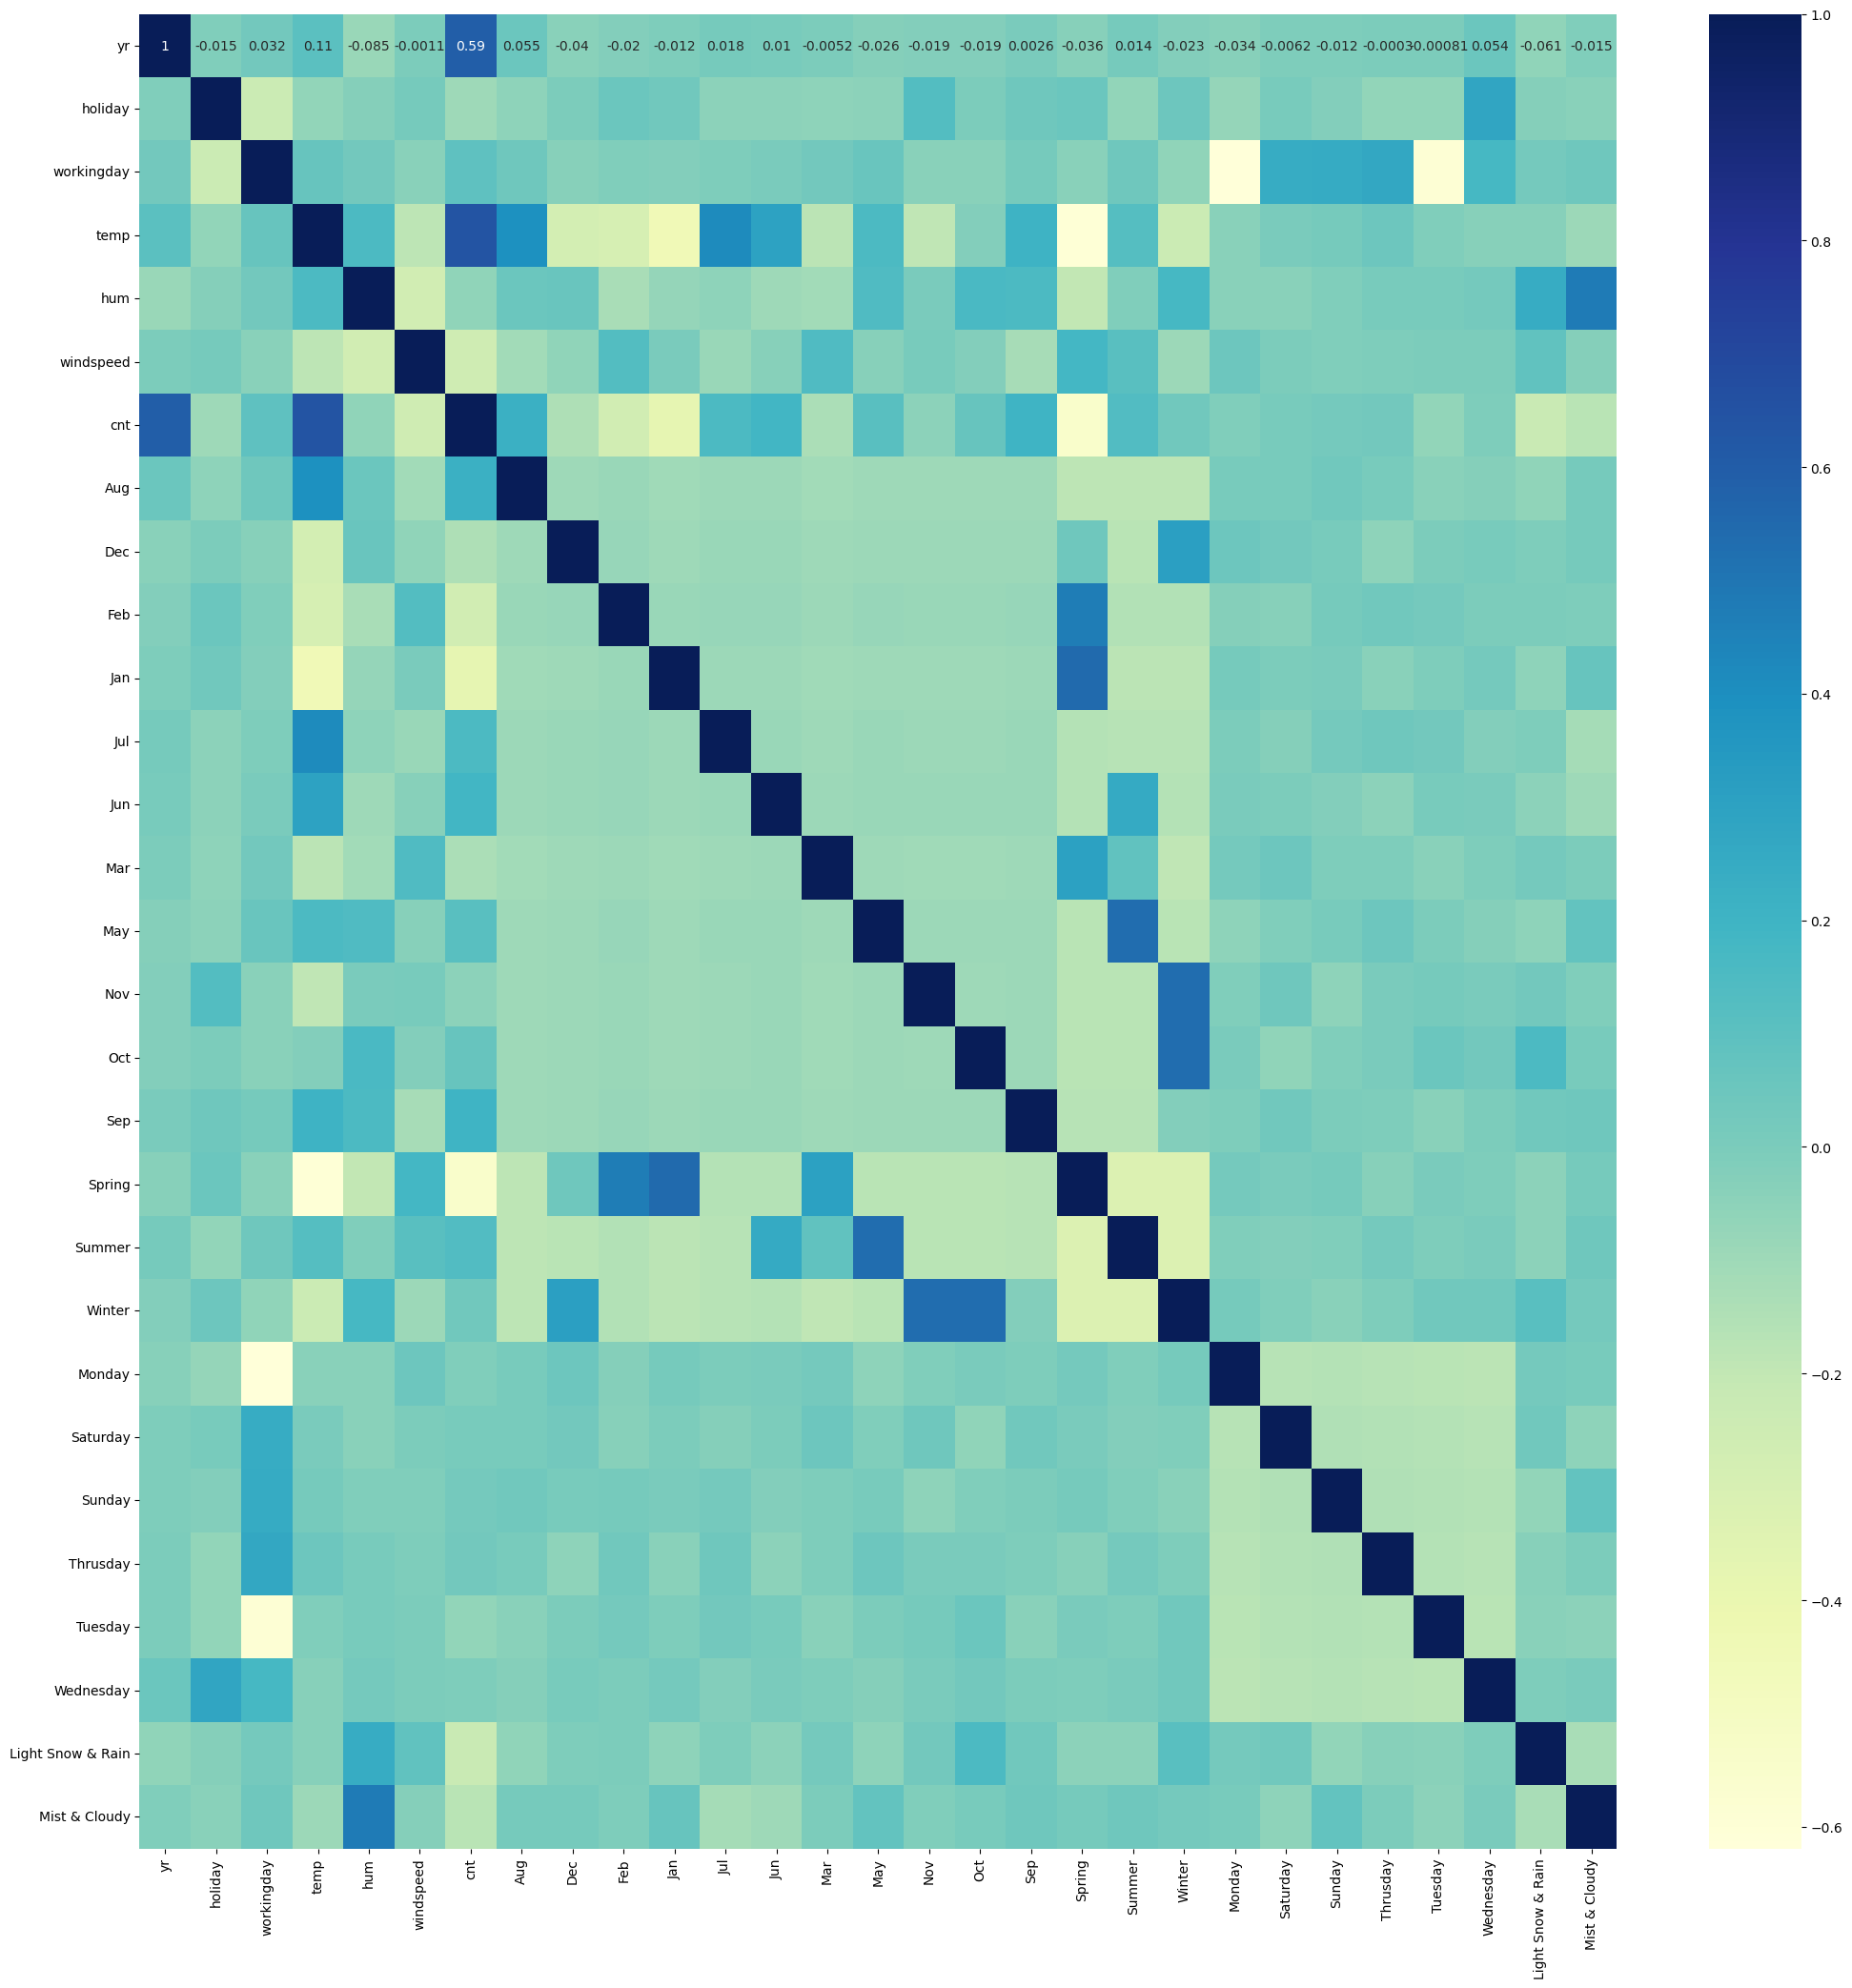

In [37]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (25, 25))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

Observation : Top 2 correlations with count variable: temp, yr 

## Step 5.1: Building a linear model

In [38]:
# dividing into y train and x train
y_train = df_train.pop('cnt')
X_train = df_train

In [39]:
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,Aug,Dec,Feb,Jan,...,Summer,Winter,Monday,Saturday,Sunday,Thrusday,Tuesday,Wednesday,Light Snow & Rain,Mist & Cloudy
653,1,0,1,0.509887,0.575354,0.300794,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
576,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
728,1,0,0,0.245101,0.498067,0.663106,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1


### There are multiple ways select features
- Manual method: By selecting 1 or a set of features and building a model by recursively adding or removing variables.
- Automated Method: Using RFE
- Mixed: Using both of the above 2 methods

#### RFE with 10 variable

In [40]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=10)            # running RFE
rfe = rfe.fit(X_train, y_train)

In [41]:
# Displaying the selected features and the assigned ranks to all features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 5),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Aug', False, 11),
 ('Dec', False, 8),
 ('Feb', False, 9),
 ('Jan', False, 6),
 ('Jul', True, 1),
 ('Jun', False, 18),
 ('Mar', False, 19),
 ('May', False, 10),
 ('Nov', False, 7),
 ('Oct', False, 15),
 ('Sep', True, 1),
 ('Spring', True, 1),
 ('Summer', False, 3),
 ('Winter', True, 1),
 ('Monday', False, 4),
 ('Saturday', False, 17),
 ('Sunday', False, 16),
 ('Thrusday', False, 14),
 ('Tuesday', False, 12),
 ('Wednesday', False, 13),
 ('Light Snow & Rain', True, 1),
 ('Mist & Cloudy', False, 2)]

In [42]:
# checking RFE Support for selecting
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'Jul', 'Sep', 'Spring',
       'Winter', 'Light Snow & Rain'],
      dtype='object')

In [43]:
# checking the length 
len(col)

10

In [44]:
# negating the col which are not selected 
X_train.columns[~rfe.support_]

Index(['workingday', 'Aug', 'Dec', 'Feb', 'Jan', 'Jun', 'Mar', 'May', 'Nov',
       'Oct', 'Summer', 'Monday', 'Saturday', 'Sunday', 'Thrusday', 'Tuesday',
       'Wednesday', 'Mist & Cloudy'],
      dtype='object')

In [45]:
# Model 1 with 10 variables in RFE
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)

# Running the linear model
lm_1_10 = sm.OLS(y_train,X_train_rfe).fit()   

In [46]:
#Summary of our linear model
lm_1_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     242.9
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          1.53e-184
Time:                        20:02:37   Log-Likelihood:                 489.69
No. Observations:                 510   AIC:                            -957.4
Df Residuals:                     499   BIC:                            -910.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3769      0.031     12.133      0.000       0.316       0.438
yr                    0.2281      0.008     27.102      0.000       0.212       0.245
holiday              -0.0920      0.026     -3.472      0.001      -0.144      -0.040
temp                  0.5147      0.031     16.542      0.000       0.454       0.576
hum                  -0.2728      0.032     -8.542      0.000      -0.336      -0.210
windspeed            -0.1887      0.026     -7.194      0.000      -0.240      -0.137
Jul                  -0.0805      0.018     -4.538      0.000      -0.115      -0.046
Sep                   0.0598      0.016      3.723      0.000       0.028       0.091
Spring               -0.1005      0.015     -6.536      0.000      -0.131      -0.070
Winter                0.0653      0.013      5.153      0.000       0.040       0.090
Light Snow & Rain    -0.1980      0.026     -7.659      0.000      -0.249      -0.147
==============================================================================
Omnibus:                       51.023   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.492
Skew:                          -0.593   Prob(JB):                     1.51e-22
Kurtosis:                       4.823   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# Droping the const for calculating vif
X_train_new = X_train_rfe.drop(["const"], axis = 1)

In [48]:
# VIF
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,15.18
2,temp,13.09
4,windspeed,4.02
7,Spring,2.40
0,yr,2.06
8,Winter,1.98
5,Jul,1.40
6,Sep,1.20
9,Light Snow & Rain,1.11
1,holiday,1.04


### Model 2

In [49]:
# dropping one variable which is having high VIF value
X_train_new = X_train_new.drop(["hum"], axis = 1)

In [50]:
# Adding a constant variable 
X_train_new = sm.add_constant(X_train_new)

# Running the linear model
lm_2_10 = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

# Summary of our linear model
lm_2_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     228.8
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          5.33e-171
Time:                        20:02:37   Log-Likelihood:                 454.89
No. Observations:                 510   AIC:                            -889.8
Df Residuals:                     500   BIC:                            -847.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2042      0.025      8.095      0.000       0.155       0.254
yr                    0.2350      0.009     26.233      0.000       0.217       0.253
holiday              -0.0862      0.028     -3.041      0.002      -0.142      -0.030
temp                  0.4758      0.033     14.453      0.000       0.411       0.540
windspeed            -0.1325      0.027     -4.879      0.000      -0.186      -0.079
Jul                  -0.0616      0.019     -3.272      0.001      -0.099      -0.025
Sep                   0.0498      0.017      2.911      0.004       0.016       0.083
Spring               -0.1032      0.016     -6.274      0.000      -0.136      -0.071
Winter                0.0504      0.013      3.754      0.000       0.024       0.077
Light Snow & Rain    -0.2562      0.027     -9.608      0.000      -0.309      -0.204
==============================================================================
Omnibus:                       62.894   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.633
Skew:                          -0.736   Prob(JB):                     4.71e-26
Kurtosis:                       4.823   Cond. No.                         13.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# Dropping the const for calculating vif
X_train_new = X_train_new.drop(["const"], axis = 1)

In [52]:
# VIF
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,4.40
3,windspeed,3.98
0,yr,2.06
6,Spring,1.61
7,Winter,1.37
4,Jul,1.34
5,Sep,1.20
8,Light Snow & Rain,1.06
1,holiday,1.04


#### Here the R-squared Value is around 80%, let's try to take more features and run the model

_Basis of feature Elimination or Addition_:
- Variance Inflation Factor (VIF)
- p-value
- R^2 of the model

#### RFE with 15 Features

In [53]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=15)            # running RFE
rfe = rfe.fit(X_train, y_train)

In [54]:
# Displaying the selected features and the assigned ranks to all features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Aug', False, 6),
 ('Dec', False, 3),
 ('Feb', False, 4),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 13),
 ('Mar', False, 14),
 ('May', False, 5),
 ('Nov', False, 2),
 ('Oct', False, 10),
 ('Sep', True, 1),
 ('Spring', True, 1),
 ('Summer', True, 1),
 ('Winter', True, 1),
 ('Monday', True, 1),
 ('Saturday', False, 12),
 ('Sunday', False, 11),
 ('Thrusday', False, 9),
 ('Tuesday', False, 7),
 ('Wednesday', False, 8),
 ('Light Snow & Rain', True, 1),
 ('Mist & Cloudy', True, 1)]

In [55]:
# checking RFE Support for selecting
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'Jan', 'Jul',
       'Sep', 'Spring', 'Summer', 'Winter', 'Monday', 'Light Snow & Rain',
       'Mist & Cloudy'],
      dtype='object')

In [56]:
# checking the length 
len(col)

15

In [57]:
# negating the col which are not selected 
X_train.columns[~rfe.support_]

Index(['Aug', 'Dec', 'Feb', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Saturday',
       'Sunday', 'Thrusday', 'Tuesday', 'Wednesday'],
      dtype='object')

In [58]:
# As observed before, VIF needs to be calculated after every model, hence writing this function to reduce writing of repetitive code
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

### Model 1

In [59]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)

# Running the linear model
lm_1 = sm.OLS(y_train,X_train_rfe).fit()  

#Summary of our linear model
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.6
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          2.31e-191
Time:                        20:02:37   Log-Likelihood:                 519.88
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     494   BIC:                            -940.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2510      0.036      6.949      0.000       0.180       0.322
yr                    0.2305      0.008     28.807      0.000       0.215       0.246
holiday              -0.0585      0.027     -2.178      0.030      -0.111      -0.006
workingday            0.0435      0.012      3.781      0.000       0.021       0.066
temp                  0.5098      0.034     14.851      0.000       0.442       0.577
hum                  -0.1547      0.037     -4.145      0.000      -0.228      -0.081
windspeed            -0.1860      0.025     -7.301      0.000      -0.236      -0.136
Jan                  -0.0343      0.017     -1.980      0.048      -0.068      -0.000
Jul                  -0.0532      0.018     -2.947      0.003      -0.089      -0.018
Sep                   0.0812      0.016      4.934      0.000       0.049       0.114
Spring               -0.0508      0.021     -2.461      0.014      -0.091      -0.010
Summer                0.0497      0.015      3.346      0.001       0.020       0.079
Winter                0.0944      0.017      5.479      0.000       0.061       0.128
Monday                0.0537      0.014      3.707      0.000       0.025       0.082
Light Snow & Rain    -0.2488      0.026     -9.560      0.000      -0.300      -0.198
Mist & Cloudy        -0.0578      0.010     -5.574      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       66.344   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.565
Skew:                          -0.676   Prob(JB):                     8.25e-36
Kurtosis:                       5.403   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
# Droping the const for calculating vif
X_train_new = X_train_rfe.drop(["const"], axis = 1)
# VIF
calculate_vif(X_train_new)

             Features    VIF
4                 hum  29.40
3                temp  17.77
2          workingday   5.31
5           windspeed   4.73
9              Spring   4.53
11             Winter   3.48
10             Summer   2.84
14      Mist & Cloudy   2.29
0                  yr   2.09
12             Monday   1.98
6                 Jan   1.67
7                 Jul   1.59
8                 Sep   1.39
13  Light Snow & Rain   1.25
1             holiday   1.18


### Model 2

In [61]:
# dropping one variable which is having high VIF value (as all -values are below 0.05)
X_train_new = X_train_new.drop(["hum"], axis = 1)

In [62]:
# Adding a constant variable 
X_train_new = sm.add_constant(X_train_new)

# Running the linear model
lm_2 = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

# Summary of our linear model
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     190.3
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          7.33e-189
Time:                        20:02:37   Log-Likelihood:                 511.16
No. Observations:                 510   AIC:                            -992.3
Df Residuals:                     495   BIC:                            -928.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1737      0.031      5.525      0.000       0.112       0.235
yr                    0.2344      0.008     29.019      0.000       0.218       0.250
holiday              -0.0562      0.027     -2.058      0.040      -0.110      -0.003
workingday            0.0465      0.012      3.983      0.000       0.024       0.069
temp                  0.4728      0.034     14.037      0.000       0.407       0.539
windspeed            -0.1563      0.025     -6.292      0.000      -0.205      -0.107
Jan                  -0.0389      0.018     -2.215      0.027      -0.073      -0.004
Jul                  -0.0482      0.018     -2.635      0.009      -0.084      -0.012
Sep                   0.0753      0.017      4.522      0.000       0.043       0.108
Spring               -0.0597      0.021     -2.861      0.004      -0.101      -0.019
Summer                0.0434      0.015      2.890      0.004       0.014       0.073
Winter                0.0797      0.017      4.650      0.000       0.046       0.113
Monday                0.0584      0.015      3.980      0.000       0.030       0.087
Light Snow & Rain    -0.2917      0.024    -12.027      0.000      -0.339      -0.244
Mist & Cloudy        -0.0826      0.009     -9.592      0.000      -0.100      -0.066
==============================================================================
Omnibus:                       67.959   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.078
Skew:                          -0.690   Prob(JB):                     8.64e-37
Kurtosis:                       5.431   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
# Dropping the const for calculating vif
X_train_new = X_train_new.drop(["const"], axis = 1)
# VIF
calculate_vif(X_train_new)

             Features   VIF
3                temp  7.07
2          workingday  5.24
4           windspeed  4.67
8              Spring  3.08
9              Summer  2.33
0                  yr  2.08
10             Winter  1.99
11             Monday  1.97
5                 Jan  1.62
6                 Jul  1.59
13      Mist & Cloudy  1.57
7                 Sep  1.35
1             holiday  1.17
12  Light Snow & Rain  1.09


### Model 3

In [64]:
# While all p-values are less than 0.05 where as we have 2 variables with VIF values.
# Based on the coeff of temp, it has a good impact on model compared to workingday.
# Let's first remove temp and workingday paralelly on lm_2 and see it's impact
X_train_new = X_train_new.drop(["temp"], axis = 1)

#### Model 3.1

In [65]:
# Adding a constant variable 
X_train_new = sm.add_constant(X_train_new)

# Running the linear model
lm_3 = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

# Summary of our linear model
lm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     136.0
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          4.04e-154
Time:                        20:02:37   Log-Likelihood:                 425.72
No. Observations:                 510   AIC:                            -823.4
Df Residuals:                     496   BIC:                            -764.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5448      0.020     27.136      0.000       0.505       0.584
yr                    0.2478      0.009     26.156      0.000       0.229       0.266
holiday              -0.0571      0.032     -1.771      0.077      -0.120       0.006
workingday            0.0480      0.014      3.482      0.001       0.021       0.075
windspeed            -0.1878      0.029     -6.429      0.000      -0.245      -0.130
Jan                  -0.1024      0.020     -5.104      0.000      -0.142      -0.063
Jul                  -0.0099      0.021     -0.461      0.645      -0.052       0.032
Sep                   0.0708      0.020      3.601      0.000       0.032       0.109
Spring               -0.2603      0.018    -14.490      0.000      -0.296      -0.225
Summer               -0.0440      0.016     -2.729      0.007      -0.076      -0.012
Winter               -0.0749      0.016     -4.829      0.000      -0.105      -0.044
Monday                0.0564      0.017      3.252      0.001       0.022       0.090
Light Snow & Rain    -0.3045      0.029    -10.634      0.000      -0.361      -0.248
Mist & Cloudy        -0.0896      0.010     -8.824      0.000      -0.110      -0.070
==============================================================================
Omnibus:                       34.622   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.832
Skew:                          -0.419   Prob(JB):                     3.07e-15
Kurtosis:                       4.563   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
# Dropping the const for calculating vif
X_train_new = X_train_new.drop(["const"], axis = 1)
# VIF
calculate_vif(X_train_new)

             Features   VIF
3           windspeed  4.27
2          workingday  3.83
7              Spring  2.97
8              Summer  2.27
9              Winter  1.99
0                  yr  1.91
10             Monday  1.69
4                 Jan  1.60
12      Mist & Cloudy  1.56
5                 Jul  1.30
6                 Sep  1.25
1             holiday  1.13
11  Light Snow & Rain  1.08


_Observation:_ r-square value went from 0.843 to 0.781, which is a significant dip

#### Model 3.2

In [67]:
# Adding temp back
X_train_new['temp'] = X_train['temp']
# Removing workday which has high VIF
X_train_new = X_train_new.drop(["workingday"], axis = 1)

In [68]:
# Adding a constant variable 
X_train_new = sm.add_constant(X_train_new)

# Running the linear model
lm_3 = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

# Summary of our linear model
lm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     197.8
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          1.21e-186
Time:                        20:02:37   Log-Likelihood:                 503.12
No. Observations:                 510   AIC:                            -978.2
Df Residuals:                     496   BIC:                            -919.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2121      0.030      6.986      0.000       0.152       0.272
yr                    0.2346      0.008     28.628      0.000       0.219       0.251
holiday              -0.0939      0.026     -3.614      0.000      -0.145      -0.043
windspeed            -0.1570      0.025     -6.231      0.000      -0.207      -0.108
Jan                  -0.0383      0.018     -2.146      0.032      -0.073      -0.003
Jul                  -0.0512      0.019     -2.758      0.006      -0.088      -0.015
Sep                   0.0760      0.017      4.498      0.000       0.043       0.109
Spring               -0.0613      0.021     -2.895      0.004      -0.103      -0.020
Summer                0.0425      0.015      2.791      0.005       0.013       0.072
Winter                0.0769      0.017      4.425      0.000       0.043       0.111
Monday                0.0201      0.011      1.788      0.074      -0.002       0.042
Light Snow & Rain    -0.2869      0.025    -11.668      0.000      -0.335      -0.239
Mist & Cloudy        -0.0808      0.009     -9.256      0.000      -0.098      -0.064
temp                  0.4741      0.034     13.868      0.000       0.407       0.541
==============================================================================
Omnibus:                       66.334   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.828
Skew:                          -0.715   Prob(JB):                     5.86e-32
Kurtosis:                       5.174   Cond. No.                         17.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
# Dropping the const for calculating vif
X_train_new = X_train_new.drop(["const"], axis = 1)
# VIF
calculate_vif(X_train_new)

             Features   VIF
12               temp  5.16
2           windspeed  4.64
6              Spring  2.76
7              Summer  2.23
0                  yr  2.07
8              Winter  1.80
3                 Jan  1.61
4                 Jul  1.59
11      Mist & Cloudy  1.56
5                 Sep  1.34
9              Monday  1.19
10  Light Snow & Rain  1.08
1             holiday  1.05


_Observation:_ r-square value went from 0.843 to 0.838, which is not a significant dip. Hence, removing workingday instead of temp

### Model 4

In [70]:
# Since it is marginally significant (p-value of 0.074), removing it from the model 
X_train_new = X_train_new.drop(["Monday"], axis = 1)

In [71]:
# Adding a constant variable 
X_train_new = sm.add_constant(X_train_new)

# Running the linear model
lm_4 = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

# Summary of our linear model
lm_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     213.1
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          3.97e-187
Time:                        20:02:37   Log-Likelihood:                 501.48
No. Observations:                 510   AIC:                            -977.0
Df Residuals:                     497   BIC:                            -921.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2155      0.030      7.096      0.000       0.156       0.275
yr                    0.2342      0.008     28.524      0.000       0.218       0.250
holiday              -0.0973      0.026     -3.747      0.000      -0.148      -0.046
windspeed            -0.1549      0.025     -6.140      0.000      -0.205      -0.105
Jan                  -0.0380      0.018     -2.125      0.034      -0.073      -0.003
Jul                  -0.0507      0.019     -2.728      0.007      -0.087      -0.014
Sep                   0.0762      0.017      4.500      0.000       0.043       0.110
Spring               -0.0615      0.021     -2.898      0.004      -0.103      -0.020
Summer                0.0422      0.015      2.766      0.006       0.012       0.072
Winter                0.0771      0.017      4.424      0.000       0.043       0.111
Light Snow & Rain    -0.2864      0.025    -11.623      0.000      -0.335      -0.238
Mist & Cloudy        -0.0807      0.009     -9.222      0.000      -0.098      -0.063
temp                  0.4728      0.034     13.803      0.000       0.405       0.540
==============================================================================
Omnibus:                       59.984   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.130
Skew:                          -0.637   Prob(JB):                     2.75e-30
Kurtosis:                       5.187   Cond. No.                         17.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
# Dropping the const for calculating vif
X_train_new = X_train_new.drop(["const"], axis = 1)
# VIF
calculate_vif(X_train_new)

             Features   VIF
11               temp  5.13
2           windspeed  4.61
6              Spring  2.75
7              Summer  2.22
0                  yr  2.07
8              Winter  1.79
3                 Jan  1.61
4                 Jul  1.59
10      Mist & Cloudy  1.56
5                 Sep  1.34
9   Light Snow & Rain  1.08
1             holiday  1.04


### Model 5

In [73]:
# Since Summer has a smaller coefficient and is less significant relative to others, it might be a good candidate for removal.
X_train_new = X_train_new.drop(["Summer"], axis = 1)

In [74]:
# Adding a constant variable 
X_train_new = sm.add_constant(X_train_new)

# Running the linear model
lm_5 = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

# Summary of our linear model
lm_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     228.7
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          1.13e-186
Time:                        20:02:37   Log-Likelihood:                 497.58
No. Observations:                 510   AIC:                            -971.2
Df Residuals:                     498   BIC:                            -920.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2657      0.025     10.843      0.000       0.218       0.314
yr                    0.2348      0.008     28.426      0.000       0.219       0.251
holiday              -0.0977      0.026     -3.738      0.000      -0.149      -0.046
windspeed            -0.1482      0.025     -5.863      0.000      -0.198      -0.099
Jan                  -0.0427      0.018     -2.382      0.018      -0.078      -0.007
Jul                  -0.0693      0.017     -3.967      0.000      -0.104      -0.035
Sep                   0.0587      0.016      3.710      0.000       0.028       0.090
Spring               -0.1013      0.016     -6.459      0.000      -0.132      -0.071
Winter                0.0432      0.012      3.462      0.001       0.019       0.068
Light Snow & Rain    -0.2877      0.025    -11.601      0.000      -0.336      -0.239
Mist & Cloudy        -0.0802      0.009     -9.106      0.000      -0.097      -0.063
temp                  0.4335      0.031     13.817      0.000       0.372       0.495
==============================================================================
Omnibus:                       58.998   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.235
Skew:                          -0.614   Prob(JB):                     5.83e-31
Kurtosis:                       5.246   Cond. No.                         14.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
# Dropping the const for calculating vif
X_train_new = X_train_new.drop(["const"], axis = 1)
# VIF
calculate_vif(X_train_new)

             Features   VIF
10               temp  4.63
2           windspeed  4.00
6              Spring  2.25
0                  yr  2.06
3                 Jan  1.60
9       Mist & Cloudy  1.53
7              Winter  1.40
4                 Jul  1.36
5                 Sep  1.20
8   Light Snow & Rain  1.08
1             holiday  1.04


_Observation_: Now, VIF for all variables in less than 5.

### Model 6

In [76]:
# t has the lowest significance (p-value of 0.018) and the smallest coefficient among the significant predictors.
X_train_new = X_train_new.drop(["Jan"], axis = 1)

In [77]:
# Adding a constant variable 
X_train_new = sm.add_constant(X_train_new)

# Running the linear model
lm_6 = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

# Summary of our linear model
lm_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     248.7
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          1.16e-186
Time:                        20:02:37   Log-Likelihood:                 494.70
No. Observations:                 510   AIC:                            -967.4
Df Residuals:                     499   BIC:                            -920.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2519      0.024     10.530      0.000       0.205       0.299
yr                    0.2341      0.008     28.224      0.000       0.218       0.250
holiday              -0.0986      0.026     -3.752      0.000      -0.150      -0.047
windspeed            -0.1398      0.025     -5.559      0.000      -0.189      -0.090
Jul                  -0.0727      0.017     -4.160      0.000      -0.107      -0.038
Sep                   0.0577      0.016      3.635      0.000       0.027       0.089
Spring               -0.1108      0.015     -7.265      0.000      -0.141      -0.081
Winter                0.0473      0.012      3.804      0.000       0.023       0.072
Light Snow & Rain    -0.2864      0.025    -11.499      0.000      -0.335      -0.237
Mist & Cloudy        -0.0811      0.009     -9.182      0.000      -0.098      -0.064
temp                  0.4515      0.031     14.758      0.000       0.391       0.512
==============================================================================
Omnibus:                       58.020   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.195
Skew:                          -0.601   Prob(JB):                     9.80e-31
Kurtosis:                       5.249   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
# Dropping the const for calculating vif
X_train_new = X_train_new.drop(["const"], axis = 1)
# VIF
calculate_vif(X_train_new)

            Features   VIF
9               temp  4.60
2          windspeed  4.00
0                 yr  2.06
5             Spring  1.65
8      Mist & Cloudy  1.51
6             Winter  1.40
3                Jul  1.35
4                Sep  1.20
7  Light Snow & Rain  1.08
1            holiday  1.04


In [79]:
r2_train = lm_6.rsquared
adj_r2_train = lm_6.rsquared_adj

print(f'R2 Score of Train Model: {r2_train}')
print(f'Adjusted R2 Score of Train Model: {adj_r2_train}')

R2 Score of Train Model: 0.8328664237258241
Adjusted R2 Score of Train Model: 0.8295170534598085


## Step 6: Residual Analysis of the train data


In [80]:
# adding constant for x train variable
X_train_new = sm.add_constant(X_train_new)

In [81]:
# Calculating the y train predict values
y_train_cnt_pre = lm_6.predict(X_train_new)

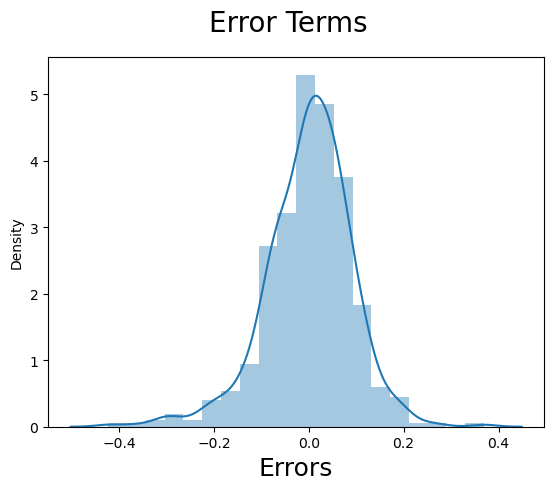

In [82]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt_pre), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label
plt.show()

In [83]:
residuals = y_train.values-y_train_cnt_pre
mean_residuals = round(np.mean(residuals))
print("Mean_Residuals: {}".format(mean_residuals))

Mean_Residuals: 0


Text(0.5, 0, 'Errors')

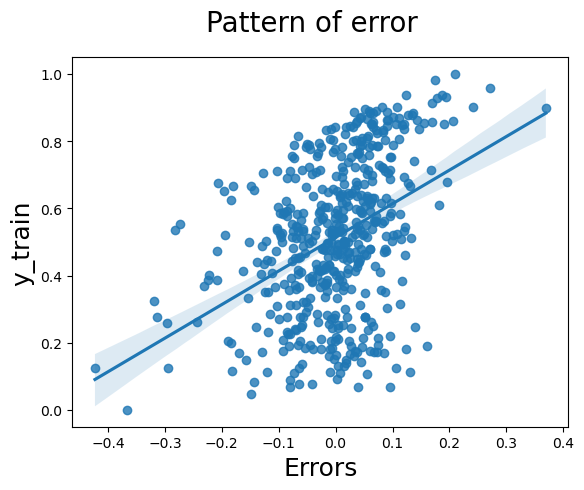

In [84]:
fig = plt.figure()
sns.regplot(x = (y_train - y_train_cnt_pre), y = y_train)
fig.suptitle('Pattern of error', fontsize = 20)                  # Plot heading 
plt.ylabel('y_train', fontsize = 18) 
plt.xlabel('Errors', fontsize = 18)

## Step 7: Making Predictions Using the Finest Model

In [85]:
# Scalling the numerical values
num_vars_1 = ['cnt','temp', 'hum', 'windspeed']

df_test[num_vars_1] = scaler.transform(df_test[num_vars_1])
df_test.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,Aug,Dec,Feb,...,Summer,Winter,Monday,Saturday,Sunday,Thrusday,Tuesday,Wednesday,Light Snow & Rain,Mist & Cloudy
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.036530,0.698630,0.558941,0.638508,0.313350,0.520592,0.059361,0.086758,0.100457,...,0.264840,0.232877,0.118721,0.164384,0.178082,0.164384,0.146119,0.127854,0.027397,0.319635
std,0.500722,0.188034,0.459904,0.233698,0.148974,0.159947,0.218435,0.236840,0.282125,0.301297,...,0.442259,0.423633,0.324202,0.371472,0.383458,0.371472,0.354034,0.334692,0.163612,0.467403
min,0.000000,0.000000,0.000000,0.046591,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.354650,0.527265,0.198517,0.377531,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558691,0.627737,0.299459,0.524275,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.759096,0.743928,0.403048,0.672745,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [86]:
df_test.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt', 'Aug',
       'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep',
       'Spring', 'Summer', 'Winter', 'Monday', 'Saturday', 'Sunday',
       'Thrusday', 'Tuesday', 'Wednesday', 'Light Snow & Rain',
       'Mist & Cloudy'],
      dtype='object')

In [87]:
### Dividing into X_test and y_test

In [88]:
y_test = df_test.pop('cnt')
X_test = df_test

In [89]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_train_new.drop('const',axis=1,inplace=True)
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

# Making predictions
y_pred = lm_6.predict(X_test_new)

# Step 8: Model Evaluation

Text(0, 0.5, 'y_pred')

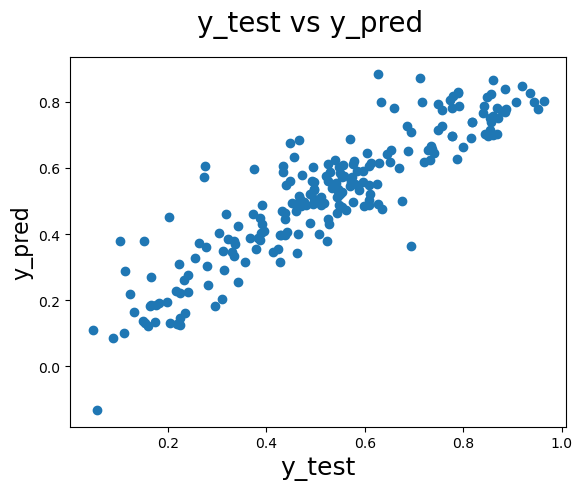

In [90]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)    

In [91]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8070101019557963

In [92]:
# Predicting Model accuracy
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score of Test Model:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.07165668005653542
Root Mean Squared Error: 0.09574033200511813
R2 Score of Test Model: 0.8070101019557963


In [93]:
# Adjusted R Square
n = X_test.shape[0]
p = X_test.shape[1]
r2_test =  metrics.r2_score(y_test, y_pred)
# We find the Adjusted R-squared using the formula
adjusted_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
print('Adjusted R2 Score of Test Model:', adjusted_r2_test)

Adjusted R2 Score of Test Model: 0.7785694854019136


In [94]:
# difference between r squared of train and test data
round((r2_train-r2_test)*100,2)

2.59

In [95]:
# diffrence of Adj R squared of train and test data
round((adj_r2_train - adjusted_r2_test),2)*100

5.0


### We can see that the equation of our best fitted line is:

___cnt___ = 0.2519   +   0.4515 * _temp_  +  0.2341 * _yr_   -   0.2864 * _Light Snow & Rain_   -   0.1398 * _windspeed_   -   0.1108 * _Spring_   -   0.0986 * _holiday_   -   0.0811 * _Mist & Cloudy_   -   0.0727 * _Jul_   +   0.0577 * _Sep_   +   0.0473 * _Winter_


__Significant variables to predict the demand for shared bikes__

- temp
- yr (1.e., 2019)
- weathersit (Light Snow & Rain, Mist & Cloudy)
- windspeed
- Season (Spring, Winter)
- months(July, September)
- holiday